In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors

import plotly.graph_objects as go
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

filename="pizza_sales.csv"
df = pd.read_csv(filename)

# 🔍 EDA (Exploratory Data Analysis)

# Tổng quan dữ liệu

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48620 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48620 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48620 non-null  object 
 10  pizza_ingredients  48620 non-null  object 
 11  pizza_name         48620 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB


In [3]:
df['order_date'] = pd.to_datetime(df['order_date'], format='%d-%m-%Y') #Chuẩn hóa kiểu dữ liệu cột "order_date" sang datetime

In [4]:
df.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


# Tổng đơn hàng và doanh thu

In [5]:
total_orders = df['order_id'].nunique()
total_revenue = df['total_price'].sum()

print(f"Tổng số đơn hàng: {total_orders}")
print(f"Tổng doanh thu: {total_revenue:,.0f} VNĐ")

Tổng số đơn hàng: 21350
Tổng doanh thu: 817,860 VNĐ


# Tổng số lượng Pizza đã bán ra

In [6]:
total_pizza_sold = df['quantity'].sum()
print(f"Tổng số lượng Pizza đã bán ra: {total_pizza_sold}")

Tổng số lượng Pizza đã bán ra: 49574


# Số lượng pizza trung bình cho mỗi đơn hàng

In [7]:
avg_Pizzas_per_order = total_pizza_sold / total_orders
print(f"Số lượng pizza trung bình cho mỗi đơn hàng: {avg_Pizzas_per_order:,.2f}")

Số lượng pizza trung bình cho mỗi đơn hàng: 2.32


# Số lượng pizza đã bán theo loại Pizza

In [8]:
total_quantity_sold = df.groupby('pizza_category')['quantity'].sum()
total_quantity_sold = pd.DataFrame(total_quantity_sold)
total_quantity_sold.sort_values(by = "quantity", ascending = False) # Hiển thị theo lớn nhất đến nhỏ nhất (theo quantity)

,quantity
pizza_category,
Classic,14888
Supreme,11987
Veggie,11649
Chicken,11050


# Số lượng đơn hàng theo ngày

In [9]:
df['Weekday'] = df['order_date'].dt.day_name()   # Monday, Tuesday, ... Sunday
orders_by_weekday = df.groupby('Weekday')['order_id'].nunique().rename("Total orders")
orders_by_weekday = orders_by_weekday.sort_values(ascending=False).reset_index()  # Hiển thị theo lớn nhất đến nhỏ nhất (theo Total orders)
orders_by_weekday

,Weekday,Total orders
0,Friday,3538
1,Thursday,3239
2,Saturday,3158
3,Wednesday,3024
4,Tuesday,2973
5,Monday,2794
6,Sunday,2624


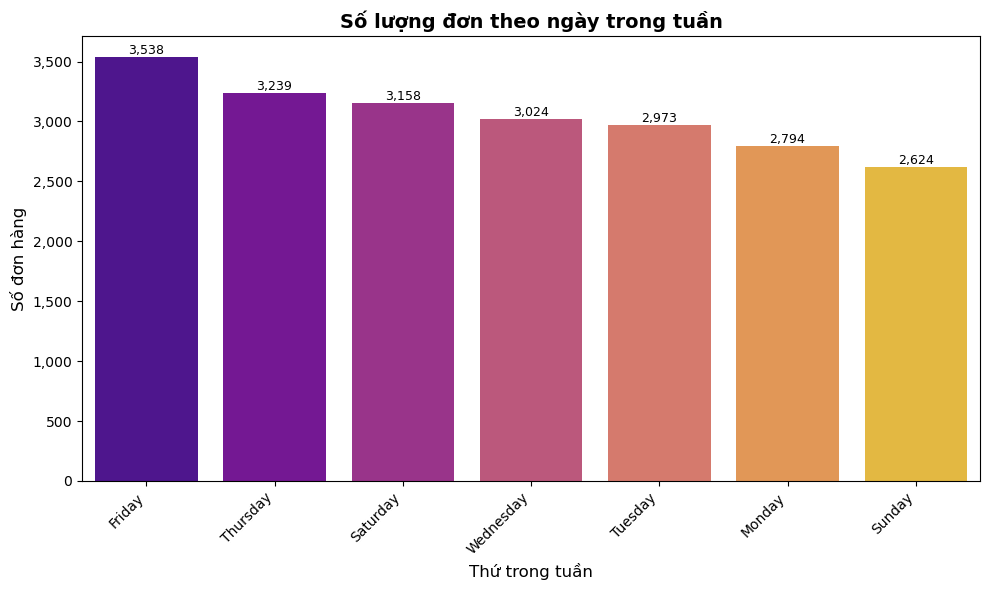

In [10]:
# Số lượng đơn hàng theo ngày

plt.figure(figsize=(10,6))
ax = sns.barplot(x='Weekday', y='Total orders', data=orders_by_weekday, palette='plasma')

ax.set_title('Số lượng đơn theo ngày trong tuần', fontsize=14, fontweight='bold')
ax.set_xlabel('Thứ trong tuần', fontsize=12)
ax.set_ylabel('Số đơn hàng', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

#  Format trục Y có dấu phẩy ngăn cách
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{int(x):,}"))

# Hiển thị số ngay trên mỗi cột
for idx, val in enumerate(orders_by_weekday['Total orders'].tolist()):
    ax.text(idx, val, f"{int(val):,}", ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()

# Doanh thu theo tháng

In [11]:
# Tạo một cột 'Month' trong dataframe df bằng cách lấy cột 'order_date' và chuyển đổi thành kiểu thời gian Period theo tháng
df['Month'] = df['order_date'].dt.to_period('M')
# Nhóm dữ liệu theo cột 'Month', tính tổng doanh thu ('Revenue') cho từng tháng và reset lại chỉ số index để tạo dataframe mới
revenue_by_month = df.groupby('Month')['total_price'].sum().rename('Revenue')

# Sắp xếp giảm dần theo Revenue rồi reset index để ra DataFrame
revenue_by_month = revenue_by_month.sort_values(ascending=False).reset_index() 
revenue_by_month

,Month,Revenue
0,2015-07,72557.90
1,2015-05,71402.75
2,2015-03,70397.10
3,2015-11,70395.35
4,2015-01,69793.30
5,2015-04,68736.80
6,2015-08,68278.25
7,2015-06,68230.20
8,2015-02,65159.60
9,2015-12,64701.15


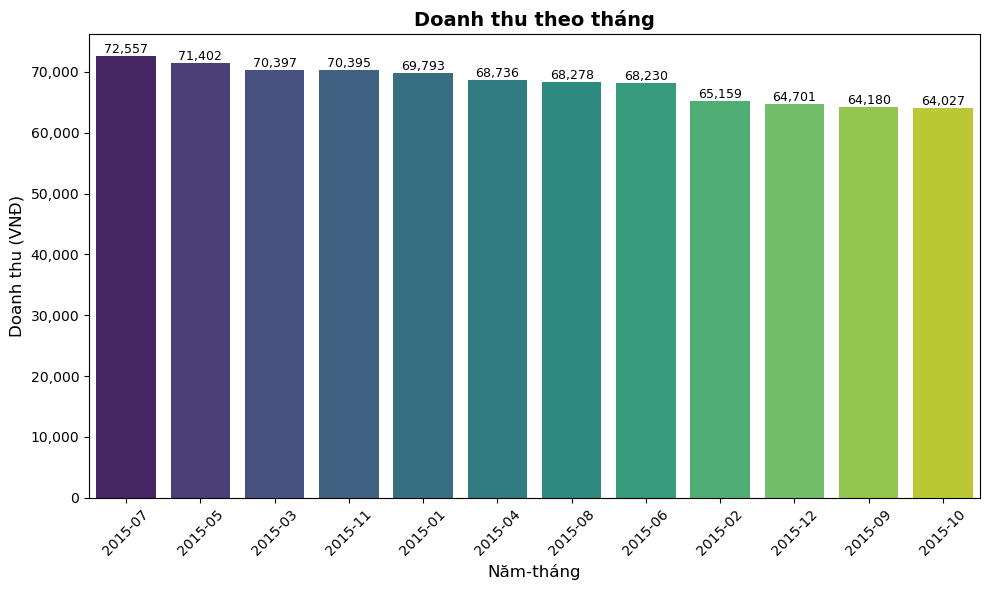

In [12]:
#Doanh thu theo tháng
plt.figure(figsize=(10,6))
ax = sns.barplot(x='Month', y='Revenue', data=revenue_by_month, palette='viridis')  # Thử màu viridis xem!

plt.title('Doanh thu theo tháng', fontsize=14, fontweight='bold')
plt.xlabel('Năm-tháng', fontsize=12)
plt.ylabel('Doanh thu (VNĐ)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Format trục Y có dấu phẩy
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))

# Hiện số trên cột
for index, row in revenue_by_month.iterrows():
    ax.text(index, row.Revenue, f"{int(row.Revenue):,}", ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()

# Doanh thu theo loại Pizza

In [13]:
rev_category = df.groupby('pizza_category')['total_price'].sum()
total_rev = df['total_price'].sum()
rev_category = pd.DataFrame(rev_category)
rev_category["PCT"] = np.round((rev_category["total_price"] / total_rev) * 100,2)
rev_category.rename(columns={'total_price': 'Revenue'}, inplace=True)
rev_category

,Revenue,PCT
pizza_category,,
Chicken,195919.50,23.96
Classic,220053.10,26.91
Supreme,208197.00,25.46
Veggie,193690.45,23.68


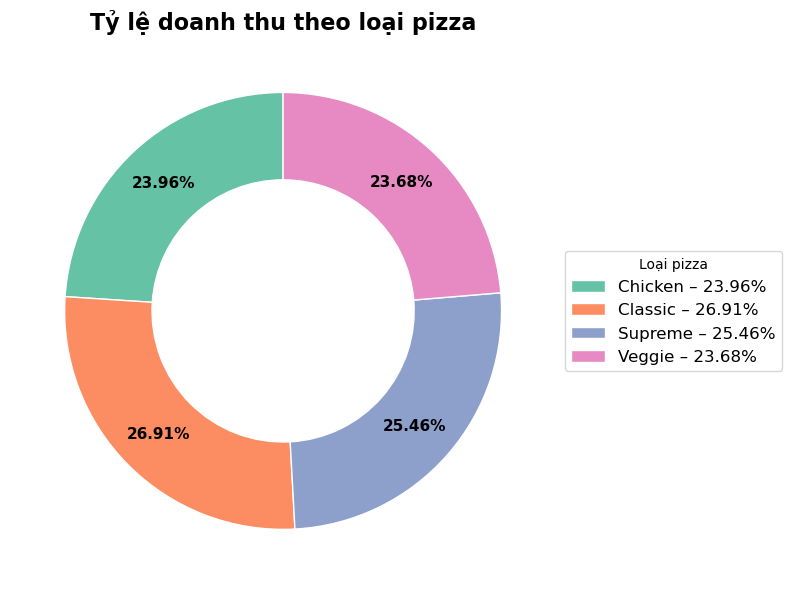

In [14]:
#Định nghĩa sizes , labels từ rev_category
sizes = rev_category["PCT"]
labels = rev_category.index
# Màu sắc đẹp
colors = sns.color_palette('Set2', n_colors=len(sizes))

fig, ax = plt.subplots(figsize=(8, 8))
wedges, _ = ax.pie(
    sizes,
    labels=None,                 # không in label mặc định
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.40, edgecolor='w')
)

# === Ghi % lên từng miếng ===
for i, w in enumerate(wedges):
    ang = (w.theta2 + w.theta1) / 2
    x = np.cos(np.deg2rad(ang)) * 0.80
    y = np.sin(np.deg2rad(ang)) * 0.80
    ax.text(x, y, f"{sizes[i]:.2f}%", ha='center', va='center',
            fontsize=11, fontweight='bold', color='black')

# === Legend bên phải (kèm % cho dễ đọc) ===
legend_labels = [f"{lab} – {sizes[i]:.2f}%" for i, lab in enumerate(labels)]
ax.legend(wedges, legend_labels, title='Loại pizza',
          loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

ax.set_title('Tỷ lệ doanh thu theo loại pizza', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

# Doanh thu theo kích thước Pizza

In [15]:
# Doanh thu theo kích thước pizza + % trên tổng
rev_size = df.groupby('pizza_size')['total_price'].sum()
total_rev = df['total_price'].sum()

rev_size = (rev_size.sort_values(ascending=False).to_frame('Revenue'))
rev_size['PCT'] = (rev_size['Revenue'] / total_rev * 100).round(2)
rev_size = rev_size.reset_index()   # có cột 'pizza_size'
rev_size

,pizza_size,Revenue,PCT
0,L,375318.70,45.89
1,M,249382.25,30.49
2,S,178076.50,21.77
3,XL,14076.00,1.72
4,XXL,1006.60,0.12


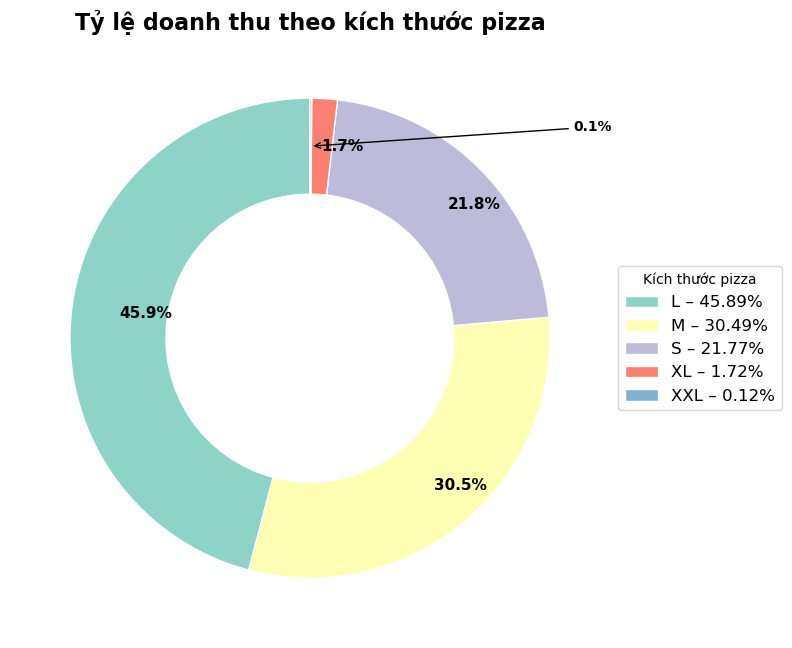

In [21]:
#Định nghĩa sizes , labels từ rev_size
sizes = rev_size["PCT"]
labels = rev_size["pizza_size"]
# Màu sắc đẹp
colors = sns.color_palette('Set3', n_colors=len(sizes))

fig, ax = plt.subplots(figsize=(8, 8))
wedges, _ = ax.pie(
    sizes,
    labels=None,                 # không in label mặc định
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.40, edgecolor='w')
)

# Viết % vào giữa từng miếng
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    x = np.cos(np.deg2rad(ang)) * 0.8 # Giảm từ 0.7 -> 0.55 để nằm bên trong hơn
    y = np.sin(np.deg2rad(ang)) * 0.8

    # Nếu phần trăm nhỏ hơn 2% thì vẽ mũi tên ra ngoài
    if sizes[i] < 1:
        ax.annotate(f"{sizes[i]:.1f}%", xy=(x, y), xytext=(1.1*np.sign(x), 1.1*y),
                    arrowprops=dict(arrowstyle="->", color='black'), ha='left', va='center', fontsize=10, fontweight='bold')
    else:
        ax.text(x, y, f"{sizes[i]:.1f}%", ha='left', va='center', fontsize=11, fontweight='bold', color='black')

# === Legend bên phải (kèm % cho dễ đọc) ===
legend_labels = [f"{lab} – {sizes[i]:.2f}%" for i, lab in enumerate(labels)]
ax.legend(wedges, legend_labels, title='Kích thước pizza',
          loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

ax.set_title('Tỷ lệ doanh thu theo kích thước pizza', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

# Top 5 tên Pizza bán chạy nhất

In [23]:
pizzaName_size = df.groupby("pizza_name")["quantity"].sum().rename("Total Orders")
pizzaName_size = pd.DataFrame(pizzaName_size)
top5_pizzaName = pizzaName_size.sort_values(by = "Total Orders",ascending=False).head(5)
top5_pizzaName = pd.DataFrame(top5_pizzaName)
top5_pizzaName

,Total Orders
pizza_name,
The Classic Deluxe Pizza,2453
The Barbecue Chicken Pizza,2432
The Hawaiian Pizza,2422
The Pepperoni Pizza,2418
The Thai Chicken Pizza,2371


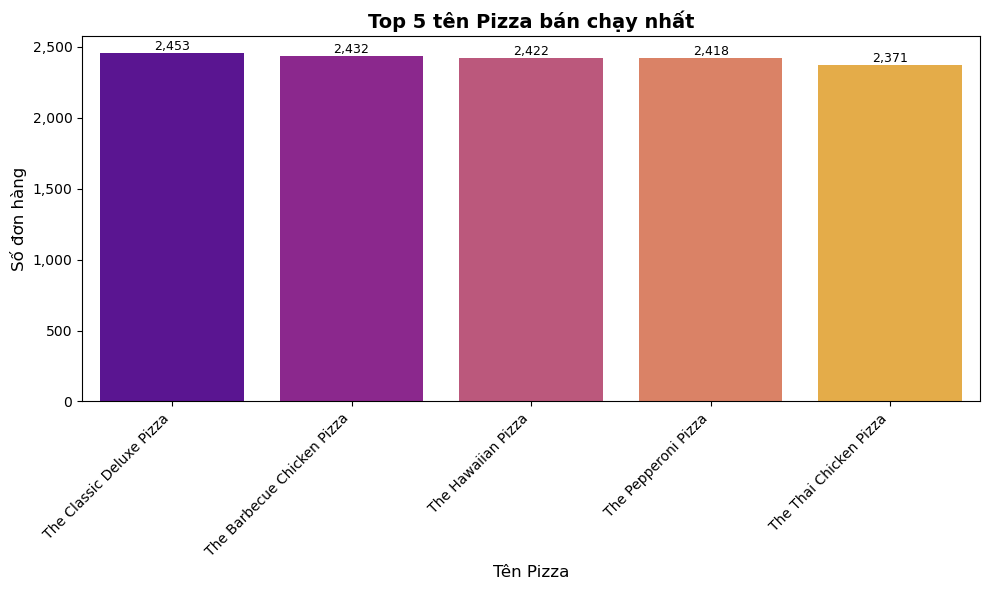

In [25]:
plt.figure(figsize=(10,6))

ax = sns.barplot(x='pizza_name', y='Total Orders', data=top5_pizzaName, palette='plasma')

ax.set_title('Top 5 tên Pizza bán chạy nhất', fontsize=14, fontweight='bold')
ax.set_xlabel('Tên Pizza', fontsize=12)
ax.set_ylabel('Số đơn hàng', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

#  Format trục Y có dấu phẩy ngăn cách
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{int(x):,}"))

# Hiển thị số ngay trên mỗi cột
for idx, val in enumerate(top5_pizzaName['Total Orders'].tolist()):
    ax.text(idx, val, f"{int(val):,}", ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()

# Bottom 5 tên Pizza bán ít nhất

In [26]:
bot5_pizzaName = pizzaName_size.sort_values(by = "Total Orders",ascending=True).head(5)
bot5_pizzaName = pd.DataFrame(bot5_pizzaName)
bot5_pizzaName

,Total Orders
pizza_name,
The Brie Carre Pizza,490
The Mediterranean Pizza,934
The Calabrese Pizza,937
The Spinach Supreme Pizza,950
The Soppressata Pizza,961


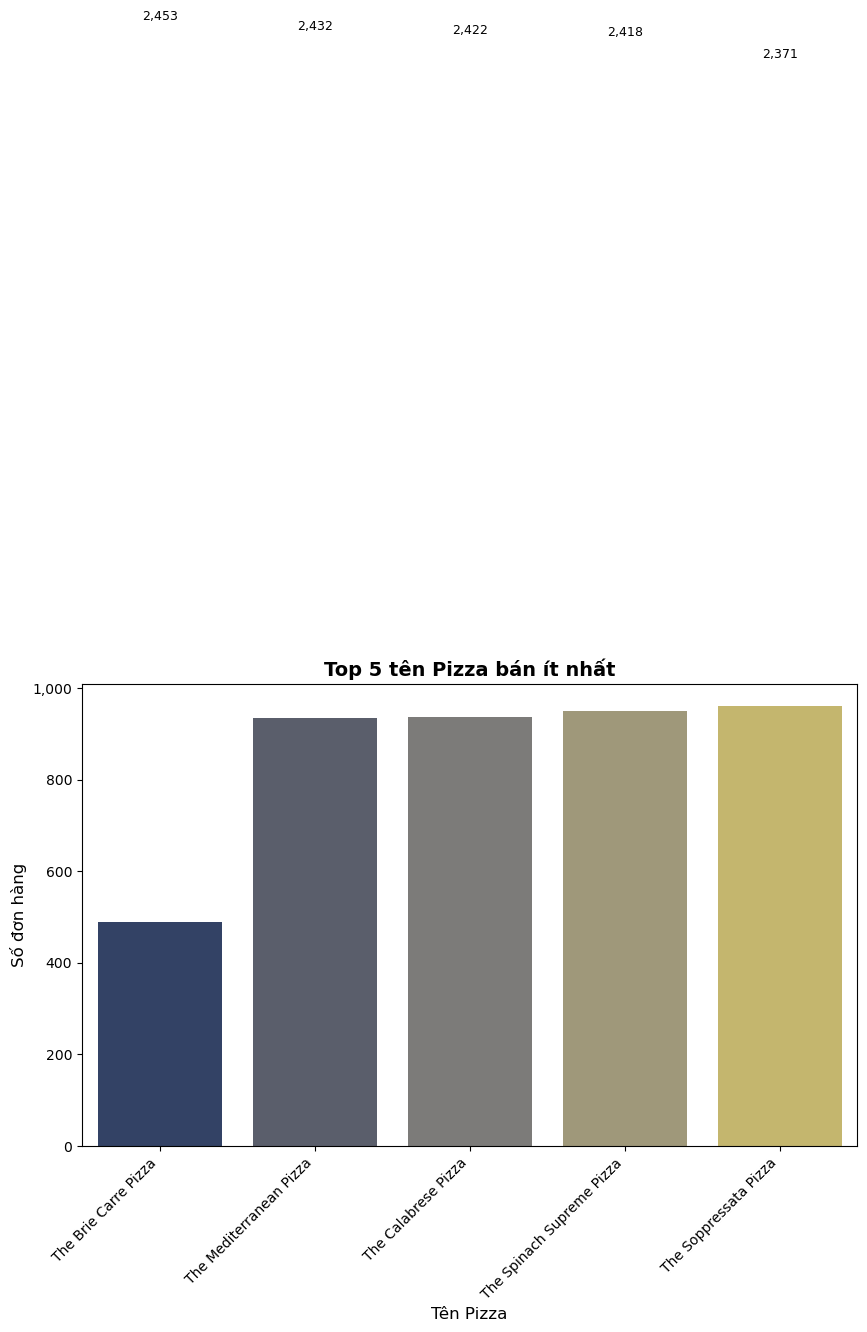

In [30]:
plt.figure(figsize=(10,6))

ax = sns.barplot(x='pizza_name', y='Total Orders', data=bot5_pizzaName, palette='cividis')

ax.set_title('Top 5 tên Pizza bán ít nhất', fontsize=14, fontweight='bold')
ax.set_xlabel('Tên Pizza', fontsize=12)
ax.set_ylabel('Số đơn hàng', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

#  Format trục Y có dấu phẩy ngăn cách
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{int(x):,}"))

# Hiển thị số ngay trên mỗi cột
for idx, val in enumerate(top5_pizzaName['Total Orders'].tolist()):
    ax.text(idx, val, f"{int(val):,}", ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()

# 💡 EDA Insights - Pizza Sales Jan-Dec 2015

## Tổng quan
- **Tổng đơn hàng:** 21,350  
- **Tổng doanh thu:** 817,860  
- **Tổng pizza bán ra:** 49,574  
- **Trung bình pizza/đơn:** 2.32  

## Theo thời gian
- **Doanh thu theo tháng (Top 3):**
  - **Tháng 7:** ~ 72,557.90
  - **Tháng 5:** ~ 71,402.75
  - **Tháng 3:** ~ 70,397.10  
> **Nhận xét:** Tháng 7 là đỉnh doanh thu năm.

## Theo ngày trong tuần
- **Nhiều đơn nhất:** **Friday** (3,538), tiếp đến **Thursday** (3,239) & **Saturday** (3,158)  
- **Ít nhất:** **Sunday** (2,624)

## Theo danh mục pizza – % doanh thu
- **Classic:** 26.91%  
- **Supreme:** 25.46%  
- **Chicken:** 23.96%  
- **Veggie:** 23.68%  

## Theo kích thước pizza – % doanh thu
- **L:** 45.89% • **M:** 30.49% • **S:** 21.77% • **XL:** 1.72% • **XXL:** 0.12%  
> **Nhận xét:** Size **L** đóng góp gần **một nửa** doanh thu.

## Top 5 tên Pizza bán chạy nhất *(theo số lượng)*
1. **The Classic Deluxe Pizza** — 2,453
2. **The Barbecue Chicken Pizza** — 2,432
3. **The Hawaiian Pizza** — 2,422
4. **The Pepperoni Pizza** — 2,418
5. **The Thai Chicken Pizza** — 2,371

## Bottom 5 tên Pizza bán ít nhất *(theo số lượng)*
1. **The Brie Carre Pizza** — 490
2. **The Mediterranean Pizza** — 934
3. **The Calabrese Pizza** — 937
4. **The Spinach Supreme Pizza** — 950
5. **The Soppressata Pizza** — 961


# 💡 Recommendations

- **Đẩy sản phẩm chủ lực (best-sellers):** The Classic Deluxe, Barbecue Chicken, Hawaiian, Pepperoni, Thai Chicken  
  → Chạy combo/upsell (pizza + drink/dessert), banner “Best choice”, giá gói cho size **L/M**.

- **Tối ưu cơ cấu size:** Size **L ~45.9%** doanh thu, **M ~30.5%**, **S ~21.8%**, **XL/XXL <2%**  
  → Ưu tiên tồn kho & chuẩn bị bột/topping cho **L/M**; cân nhắc **make-to-order** hoặc giới hạn SKU **XL/XXL** để giảm hao hụt.

- **Lịch vận hành & khuyến mãi theo ngày:** Đơn cao nhất **Fri–Sat**, thấp nhất **Sun**  
  → Tăng nhân sự/SL lò nướng Fri–Sat; tung **Sunday family deal / early-bird** để kéo nhu cầu Chủ nhật.

- **Danh mục theo category:** Classic & Supreme dẫn đầu tỷ trọng doanh thu  
  → Dùng làm **trục menu** (first view/ featured), chạy bundle 2 chiếc Classic/Supreme giá tốt.

- **Xử lý SKU bán chậm (Bottom 5):** The Brie Carre, Mediterranean, Calabrese, Spinach Supreme, Soppressata  
  → Thử A/B khuyến mãi, đổi topping/đặt lại tên; nếu < ngưỡng doanh số → **thu hẹp/retire** để tối ưu menu & nguyên liệu.

- **Theo mùa/tháng:** Doanh thu đỉnh vào **tháng 7**  
  → Chuẩn bị nguyên liệu/nhân sự sớm; thử **seasonal flavor**/mini-campaign trong giai đoạn cao điểm.